In [53]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from nltk.metrics import edit_distance
import re, nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hazeneckert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
train = pd.read_csv('Training_DataSet.csv')
test = pd.read_csv('Test_Dataset.csv')

# Info about the vehicles
[Cadillac XT5 2017-2019](https://en.wikipedia.org/wiki/Cadillac_XT5)
- Only offers a 3.6L V6 gasoline engine in the US
- Two drivetrains AWD or FWD
- One transmission 8-speed 
- Four Trim levels [Base, Luxury, Premium Luxury, Platinum]

[Jeep Grand Cherokee 2015-2019](https://en.wikipedia.org/wiki/Jeep_Grand_Cherokee_(WK2))
- 10 trim levels: [ Laredo, Laredo E, Altitude, High Altitude, Upland, Trailhawk, Limited, Sterling Edition, Overland, Summit, SRT, SRT Trackhawk]
- Offers 6 engine options:
    - 3.6L V6: Laredo, Laredo E, Altitude, Limited, Sterling Edition, Trailhawk, Overland, High Altitude, Summit
    - 5.7L V8: Limited, Limited X, Sterling Edition, Trailhawk, Overland, High Altitude, Summit
    - 6.4L V8: SRT
    - 6.2L V8: SRT Trackhawk
    - 3.0L Diesel: Limited, Overland, Summit
- The transmission is a function of year and engine
- No info about drivetrain

# Exploratory Data Analysis
ListingID is a unique identifier.

SellerCity 
- has some misspelled cities: 'Morganton' and 'Morgantown', 'Milwaukee' and 'Milwaukie', 
- has different capitalizations: 'Green Bay' and 'Green bay', 
- has some unicode symbols: 'Coeur d&#x27;Alene' and 'O&#x27;Fallon', 
- has different labels for the same location: 'Charter Twp of Clinton', 'Clinton','Clinton Township'
- is never null in training or testing
- There are cities in the test data never observed in the training data

SellerIsPriv is extremely biased towards False, 6284/6298 and is never null in training or testing.

SellerListSrc takes 8 non-null values and is null for 2 entries. These 2 null entries are also the null entries for SellerZip. All values observed in the test set is in the training set. There are no null values in the training data.

SellerName is never null. There are sellers in the test data not in the training data. There are many entries that are very similar like 'CarMax Buffalo' and 'CarMax Buford'.

SellerRating is never null in training or testing. There are 5988 nonzero entries.

SellerRevCnt is never null in training or testing. There are 6128 nonzero entries. 

SellerState has observations for each state in training. 6 states are not included in the testing data, ['HI', 'ME', 'MT', 'NM', 'OR', 'VT']. Never null in training or testing. Probably a good idea to remove HI

VehBodystyle is always 'SUV'

VehCertified is mostly false, 4879/6298. Never null in training or testing.

VehColorExt has null values in training and testing but most entries are in the top 20 or so most common colors. 

VehColorInt has null values in training and testing but most entries are in the top 10 or so most common colors. Maybe extracting the leather option would be helpful.

VehDriveTrain has null values in training and testing. There are several different names for the same thing. 

VehEngine has null values in training and testing. There are several different names for the same thing. 

Skip VehFeats for now

VehFuel has null values in the training but not the test data. Other than 'Unknown' and null entries this column is clean.

VehHistory has null values in training and testing. It seems easy to extract a small number of features from this column.

VehListdays is null for the same two entries that SellerListSrc is null. It is never null in the test set.

VehMake is never null in training or testing. It is either 'Jeep' or 'Cadillac'

VehMileage is null in training and test but very rarely, twice and once, respectively.

VehModel is never null in training or testing. It is either 'Grand Cherokee' or 'XT5'

VehPriceLabel is null in training and test but otherwise takes 3 values.

Skip VehSellerNotes for now

VehType is always 'Used'

VehTransmission is null in training and test and has a bunch of redundant labels.

VehYear is never null and the training and testing share the same 5 years.

Vehicle_Trim is null for 405 entries in training.

Dealer_Listing_Price is null for 52 entries in training.

In [55]:
train.describe(include='all')

,ListingID,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,...,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
count,6.298000e+03,6298,6298,6296,6298,6298.000000,6298.000000,6298,6296.000000,6298,...,6298,6296.000000,6298,6013,6055,6298,6101,6298.000000,5893,6246.000000
unique,NaN,1318,2,8,2452,NaN,NaN,50,NaN,1,...,2,NaN,2,3,4920,1,33,NaN,29,NaN
top,NaN,Chicago,False,Digital Motorworks (DMi),Vroom (Online Dealer - Nationwide Delivery),NaN,NaN,IL,NaN,SUV,...,Jeep,NaN,Grand Cherokee,Good Deal,CARVANA CERTIFIED INCLUDES: 150-POINT INSPECTI...,Used,8-Speed Automatic,NaN,Limited,NaN
freq,NaN,118,6284,3086,381,NaN,NaN,753,NaN,6298,...,4199,NaN,4199,4488,218,6298,4395,NaN,1912,NaN
mean,4.318130e+06,NaN,NaN,NaN,NaN,4.138346,434.565576,NaN,45234.211722,NaN,...,NaN,26369.364358,NaN,NaN,NaN,NaN,NaN,2016.792633,NaN,32265.053314
std,2.486031e+06,NaN,NaN,NaN,NaN,1.188033,1274.257411,NaN,20380.478191,NaN,...,NaN,13036.568712,NaN,NaN,NaN,NaN,NaN,1.206566,NaN,7538.339005
min,3.287000e+03,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1105.000000,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,2015.000000,NaN,18289.000000
25%,2.178112e+06,NaN,NaN,NaN,NaN,4.000000,28.000000,NaN,28806.000000,NaN,...,NaN,16835.000000,NaN,NaN,NaN,NaN,NaN,2015.000000,NaN,26900.000000
50%,4.298122e+06,NaN,NaN,NaN,NaN,4.600000,126.000000,NaN,46410.000000,NaN,...,NaN,26181.000000,NaN,NaN,NaN,NaN,NaN,2017.000000,NaN,31455.500000
75%,6.488249e+06,NaN,NaN,NaN,NaN,4.800000,401.000000,NaN,60126.000000,NaN,...,NaN,36468.500000,NaN,NaN,NaN,NaN,NaN,2018.000000,NaN,35991.000000


In [56]:
train.isnull().sum(),test.isnull().sum()

(ListingID                 0
 SellerCity                0
 SellerIsPriv              0
 SellerListSrc             2
 SellerName                0
 SellerRating              0
 SellerRevCnt              0
 SellerState               0
 SellerZip                 2
 VehBodystyle              0
 VehCertified              0
 VehColorExt              73
 VehColorInt             728
 VehDriveTrain           401
 VehEngine               361
 VehFeats                275
 VehFuel                   2
 VehHistory              201
 VehListdays               2
 VehMake                   0
 VehMileage                2
 VehModel                  0
 VehPriceLabel           285
 VehSellerNotes          243
 VehType                   0
 VehTransmission         197
 VehYear                   0
 Vehicle_Trim            405
 Dealer_Listing_Price     52
 dtype: int64,
 ListingID            0
 SellerCity           0
 SellerIsPriv         0
 SellerListSrc        0
 SellerName           0
 SellerRating         0


In [57]:
# remove capitalization 
for x in ["SellerCity","VehColorExt","VehColorInt","VehFeats", "VehSellerNotes"]:
    train[x]=train[x].str.lower()
    test[x]=test[x].str.lower()

In [58]:
train.iloc[3855]

ListingID                           5306897
SellerCity                         dearborn
SellerIsPriv                          False
SellerListSrc                           NaN
SellerName              Jack Demmer Lincoln
SellerRating                            4.8
SellerRevCnt                            261
SellerState                              MI
SellerZip                               NaN
VehBodystyle                            SUV
VehCertified                          False
VehColorExt                             NaN
VehColorInt                             NaN
VehDriveTrain                           NaN
VehEngine                               NaN
VehFeats                                NaN
VehFuel                                 NaN
VehHistory                              NaN
VehListdays                             NaN
VehMake                                Jeep
VehMileage                          36678.0
VehModel                     Grand Cherokee
VehPriceLabel                   

In [59]:
# Find the entries with null SellerListSrc
train[train.SellerListSrc.isnull()]

,ListingID,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,...,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
1125,1562581,richmond,False,NaN,Pearson Chrysler Jeep Dodge RAM,1.0,4,VA,NaN,SUV,...,Jeep,38329.0,Grand Cherokee,Good Deal,NaN,Used,NaN,2017,Limited,26333.0
3855,5306897,dearborn,False,NaN,Jack Demmer Lincoln,4.8,261,MI,NaN,SUV,...,Jeep,36678.0,Grand Cherokee,Fair Price,NaN,Used,NaN,2015,Limited,23500.0


In [60]:
train[train.SellerName.str.contains("Lincoln")]["SellerListSrc"].value_counts()

SellerListSrc
Inventory Command Center    39
Digital Motorworks (DMi)    34
HomeNet Automotive          10
Name: count, dtype: int64

Only two records have null SellerListSrc, VehFuel and SellerZip, records 1125 and 3855. Rather than drop these record or create an 'unknown' category, we are going to fill these in the best we can. We can look up the zipcodes for these dealerships. We have other entries from the seller in record 1125, which we will use to complete the SellerListSrc. For record 3855 we fill SellerListSrc using the most common source for Lincoln dealerships. We chose to fill in the VehFuel entries with Gasoline since it is the most common.

In [61]:
train.at[1125,"SellerZip"]=23294
train.at[1125,"SellerListSrc"]="HomeNet Automotive" # used this source for future sales
train.at[1125,"VehFuel"]="Gasoline"

train.at[3855,"SellerZip"]=48124 
train.at[3855,"SellerListSrc"]="Inventory Command Center" 
train.at[3855,"VehFuel"]="Gasoline" 

Two records are missing VehMileage and VehListdays, we will just fill those in with the means. 

In [62]:
train["VehMileage"].fillna(value=train["VehMileage"].mean(),inplace=True)
test["VehMileage"].fillna(value=test["VehMileage"].mean(),inplace=True)
train["VehListdays"].fillna(value=train["VehListdays"].mean(),inplace=True)

For the null VehColorExt VehColorInt VehDriveTrain VehEngine VehPriceLabel VehTransmission add an "unknown" category.

In [63]:
for x in ["VehColorExt", "VehColorInt", "VehDriveTrain", "VehEngine", "VehPriceLabel", "VehTransmission"]:
    train[x].fillna(value="unknown",inplace=True)
    test[x].fillna(value="unknown",inplace=True)
    

For many names the first token is most informative with the remaining tokens just specifying the location. To capture sellers that have multiple locations, add a feature for the first token in a name. 

In [64]:
train["SellerShortName"]=train["SellerName"].str.lower().str.split(n=1,expand=True)[0]
test["SellerShortName"]=test["SellerName"].str.lower().str.split(n=1,expand=True)[0]

There is just one data point for HI and it doesn't show up in testing. HI is likely an outlier so it is removed. 

In [65]:
train = train[train["SellerState"]!= "HI"]

We add a feature that consolidates states in their Census Bureau–designated divisions.

In [66]:
divisions = {"New England" : {"CT", "ME", "MA", "NH", "RI", "VT"},
            "Middle Atlantic" : {"NJ","NY","PA"},
             "South Atlantic" : {"MD","DC","DE","VA","WV","NC","SC","GA","FL"},
            "East North Central" : {"IL","IN","OH","MI","WI"},
             "East South Central" : {"KY","TN","MS","AL"},
            "West North Central" : {"ND","SD","NE","KS","MO","IA","MN"},
            "West South Central" : {"TX","LA","AR","OK"},
            "Mountain" : {"MT","ID","WY","NV","UT","CO","AZ","NM"},
            "Pacific" : {"AK","HI","WA","OR","CA"}}
state_to_division = dict([(state,division) for division in divisions.keys() for state in divisions[division]])
    
train["SellerDivision"] = train["SellerState"].apply(lambda state: state_to_division[state])
test["SellerDivision"] = test["SellerState"].apply(lambda state: state_to_division[state])

Normalize the labels for 4WD and FWD drivetrains. 

In [67]:
drivetrains = {
    "4WD" : ["4WD", "AWD", "4X4", "Four Wheel Drive", "ALL-WHEEL DRIVE", "All Wheel Drive", 
             "4x4", "4x4/4-wheel drive", "4x4/4WD", "AWD or 4x4", "All-wheel Drive", "ALL WHEEL", 
             "AllWheelDrive", "ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL","4WD/AWD"],
    "FWD" : ["FWD","FRONT-WHEEL DRIVE", "Front Wheel Drive","Front-wheel Drive","2WD"],
    "unknown" : ["unknown"]
}
clean_drivetrain = dict([(raw,clean) for clean in drivetrains.keys() for raw in drivetrains[clean]])
train["VehDriveTrainClean"] = train["VehDriveTrain"].apply(lambda raw: clean_drivetrain[raw])
test["VehDriveTrainClean"] = test["VehDriveTrain"].apply(lambda raw: clean_drivetrain[raw])

In [68]:
# Tokenize the engine strings
train["VehEngineTokens"] = train["VehEngine"].str.split()
test["VehEngineTokens"] = test["VehEngine"].str.split()

In [69]:
# Extract the list of features from VehFeats and generate words and bigrams
nonalphanum = re.compile("[^a-zA-Z0-9_]")
def words_and_bigrams(s):
    words = list(nltk.word_tokenize(s))
    bigrams = list(nltk.bigrams(words))
    return [(w,) for w in words] + bigrams

def extract_feats(feats):
    if pd.isna(feats):
        return [("unknown",)]
    else:
        return [gram for feat in feats.strip("]['").split("', '") for gram in words_and_bigrams(nonalphanum.sub(' ', feat).strip())]
train["VehFeatTokens"] = train["VehFeats"].apply(extract_feats)
test["VehFeatTokens"] = test["VehFeats"].apply(extract_feats)

In [70]:
# Extract words and bigrams from Seller notes
def extract_notes(notes):
    if pd.isna(notes):
        return [("unknown",)]
    else:
        return [gram for gram in words_and_bigrams(nonalphanum.sub(' ', notes).strip())]
train["VehSellerNotesTokens"] = train["VehSellerNotes"].apply(extract_notes)
test["VehSellerNotesTokens"] = test["VehSellerNotes"].apply(extract_notes)

In [71]:
# As VehHistory is standardized we just extract the elements in the list 
train["VehHistoryTokens"] = train["VehHistory"].fillna('unknown').str.split(', ')
test["VehHistoryTokens"] = test["VehHistory"].fillna('unknown').str.split(', ')

In [72]:
# Extract words and bigrams from seller names
def extract_names(name):
    if pd.isna(name):
        return [("unknown",)]
    else:
        return [gram for gram in words_and_bigrams(nonalphanum.sub(' ', name).strip())]
train["SellerNameTokens"] = train["SellerName"].apply(extract_names)
test["SellerNameTokens"] = test["SellerName"].apply(extract_names)

This next feature cleans the VehEngine feature and attempts to extract it from VehFeats or VehSellerNotes if it is unknown.

In [73]:
def extract_engine(row):
    if (not pd.isna(row["VehFeats"]) and "3.6" in row["VehFeats"]) or (not pd.isna(row["VehSellerNotes"]) and "3.6" in row["VehSellerNotes"]):
        return "3.6L V6"
    elif (not pd.isna(row["VehFeats"]) and "5.7" in row["VehFeats"]) or (not pd.isna(row["VehSellerNotes"]) and "5.7" in row["VehSellerNotes"]):
        return "5.7L V8"
    elif (not pd.isna(row["VehFeats"]) and "6.2" in row["VehFeats"]) or (not pd.isna(row["VehSellerNotes"]) and "6.2" in row["VehSellerNotes"]):
        return "6.2L V8"
    elif (not pd.isna(row["VehFeats"]) and "6.4" in row["VehFeats"]) or (not pd.isna(row["VehSellerNotes"]) and "6.4" in row["VehSellerNotes"]):
        return "6.4L V8"
    else:
        return row["VehEngine"]
def clean_train_engine(row):
    if row["VehMake"] == "Cadillac": 
        return "3.6L V6"
    elif row["VehFuel"]=="Diesel":
        return "3.0L V6"
    elif "3.6" in row["VehEngine"] or "V6" in row["VehEngine"] or row["VehEngine"] in ["6-cylinder","6","6 Cylinder","V-6 cyl"] or row["Vehicle_Trim"] in ["Laredo", "Laredo E"]:
        return "3.6L V6"
    elif "6.4" in row["VehEngine"] or row["Vehicle_Trim"] in ["SRT","SRT8"]:
        return "6.4L V8"
    elif "6.2" in row["VehEngine"] or "Trackhawk" == row["Vehicle_Trim"]:
        return "6.2L V8"
    elif "5.7" in row["VehEngine"] or ("8" in row["VehEngine"] and not (row["Vehicle_Trim"] in ["SRT","SRT8","Trackhawk"])):
        return "5.7L V8"
    else:
        return extract_engine(row)
def clean_test_engine(row):
    if row["VehMake"] == "Cadillac": 
        return "3.6L V6"
    elif row["VehFuel"]=="Diesel":
        return "3.0L V6"
    elif "3.6" in row["VehEngine"] or "V6" in row["VehEngine"] or row["VehEngine"] in ["6-cylinder","6","6 Cylinder","V-6 cyl"]:
        return "3.6L V6"
    elif "6.2" in row["VehEngine"]:
        return "6.2L V8"
    elif "6.4" in row["VehEngine"] or row["VehEngine"]=="8-cylinder": # the one "8-cylinder" has SRT in notes
        return "6.4L V8"
    elif "5.7" in row["VehEngine"] or row["VehEngine"]=="8 Cylinder Engine": # the one "8 Cylinder Engine" has uninformative features, rather than label it "unknown" I label it the most common V8 engine type
        return "5.7L V8"
    elif row["VehEngine"]=="0":
        return "unknown"
    else:
        return extract_engine(row)

train["VehEngineClean"] = train.apply(clean_train_engine,axis=1)
test["VehEngineClean"] = test.apply(clean_test_engine,axis=1)

In [74]:
# A simple attempt to extract a trim label from VehFeats or VehSellerNotes
def extract_trim(row):
    if not pd.isnull(row["VehSellerNotes"]):
        if row["VehMake"]=="Cadillac":
            if "platinum" in row["VehSellerNotes"]:
                return "Platinum"
            elif "premium luxury" in row["VehSellerNotes"]:
                return "Premium Luxury"
            elif "luxury" in row["VehSellerNotes"]:
                return "Luxury"
            elif "base" in row["VehSellerNotes"]:
                return "Base"
        else:
            if "laredo e" in row["VehSellerNotes"]:
                return "Laredo E"
            elif "laredo" in row["VehSellerNotes"]:
                return "Laredo E"
            elif "overland" in row["VehSellerNotes"]:
                return "Overland"
            elif "high altitude" in row["VehSellerNotes"]:
                return "High Altitude"
            elif "altitude" in row["VehSellerNotes"]:
                return "Altitude"
            elif "summit" in row["VehSellerNotes"]:
                return "Summit"
            elif "trailhawk" in row["VehSellerNotes"]:
                return "Trailhawk"
            elif "srt" in row["VehSellerNotes"]:
                return "SRT"
            elif "trackhawk" in row["VehSellerNotes"]:
                return "Trackhawk"
            elif "sterling edition" in row["VehSellerNotes"]:
                return "Sterling Edition"
            elif "upland" in row["VehSellerNotes"]:
                return "Upland"
            elif "limited" in row["VehSellerNotes"]:
                return "Limited"
    elif not pd.isnull(row["VehFeats"]):
        if row["VehMake"]=="Cadillac":
            if "platinum" in row["VehFeats"]:
                return "Platinum"
            elif "premium luxury" in row["VehFeats"]:
                return "Premium Luxury"
            elif "luxury" in row["VehFeats"]:
                return "Luxury"
            elif "base" in row["VehFeats"]:
                return "Base"
        else:
            if "laredo e" in row["VehFeats"]:
                return "Laredo E"
            elif "laredo" in row["VehFeats"]:
                return "Laredo E"
            elif "overland" in row["VehFeats"]:
                return "Overland"
            elif "high altitude" in row["VehFeats"]:
                return "High Altitude"
            elif "altitude" in row["VehFeats"]:
                return "Altitude"
            elif "summit" in row["VehFeats"]:
                return "Summit"
            elif "trailhawk" in row["VehFeats"]:
                return "Trailhawk"
            elif "srt" in row["VehFeats"]:
                return "SRT"
            elif "trackhawk" in row["VehFeats"]:
                return "Trackhawk"
            elif "sterling edition" in row["VehFeats"]:
                return "Sterling Edition"
            elif "upland" in row["VehFeats"]:
                return "Upland"
            elif "limited" in row["VehFeats"]:
                return "Limited"
    return "Unknown"
train["Vehicle_Trim_Extraction"] = train.apply(extract_trim,axis=1)
test["Vehicle_Trim_Extraction"] = test.apply(extract_trim,axis=1)

In [75]:
# An agressively normalized version of trim labels
def clean_trim(row):
    if pd.isnull(row["Vehicle_Trim"]):
        return row["Vehicle_Trim"]
    elif row["VehMake"]=="Cadillac":
        if row["Vehicle_Trim"] in ["Premium Luxury","Premium Luxury AWD","Premium Luxury FWD"]:
            return "Premium Luxury"
        elif row["Vehicle_Trim"] in ["Luxury","Luxury AWD","Luxury FWD"]:
            return "Luxury"
        elif row["Vehicle_Trim"] in ["Platinum","Platinum AWD"]:
            return "Platinum"
        else:
            return "Base"
    else:
        if row["Vehicle_Trim"] in ["Limited","75th Anniversary","Limited 75th Anniversary Edition","Limited 4x4","75th Anniversary Edition","Limited X","Limited 75th Anniversary"]:
            return "Limited"
        elif row["Vehicle_Trim"] in ["SRT", "SRT Night"]:
            return "SRT"
        else:
            return row["Vehicle_Trim"]
train["Vehicle_Trim_Clean"] = train.apply(clean_trim,axis=1)

In [76]:
# Replace trim levels that are used only once
train["Vehicle_Trim"].value_counts()
def clean_trim(row):
    if pd.isnull(row["Vehicle_Trim"]):
        return row["Vehicle_Trim"]
    elif row["VehMake"]=="Cadillac":
        return row["Vehicle_Trim"]
    else:
        if row["Vehicle_Trim"] in ["Limited X", "Limited 4x4"]:
            return "Limited"
        elif row["Vehicle_Trim"] in ["Limited 75th Anniversary","75th Anniversary Edition"]:
            return "75th Anniversary"
        else:
            return row["Vehicle_Trim"]
train["Vehicle_Trim_Semiclean"] = train.apply(clean_trim,axis=1)

In [77]:
# normalize unknown color labeld
def clean_ext_color(color): 
    if color == "undetermined" or color == "unspecified":
        return "unknown"
    else: 
        return color
train["VehColorExt"] = train["VehColorExt"].apply(clean_ext_color)
test["VehColorExt"] = test["VehColorExt"].apply(clean_ext_color)

In [78]:
# Extract words and bigrams from colors
def extract_color(color):
    if pd.isna(color):
        return [("unknown",)]
    else:
        return [gram for gram in words_and_bigrams(nonalphanum.sub(' ', color).strip())]
train["VehColorExtTokens"] = train["VehColorExt"].apply(extract_color)
test["VehColorExtTokens"] = test["VehColorExt"].apply(extract_color)
train["VehColorIntTokens"] = train["VehColorInt"].apply(extract_color)
test["VehColorIntTokens"] = test["VehColorInt"].apply(extract_color)

In [79]:
# Encode features for model training
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer,StandardScaler
real_features = ["SellerRating","SellerRevCnt","VehListdays","VehMileage"]
already_encoded_features = ["SellerIsPriv","VehCertified"]
one_hot_encoded_features = ["SellerListSrc","SellerState","SellerDivision","VehDriveTrainClean","VehEngineClean","VehFuel","VehMake","VehPriceLabel","VehYear","Vehicle_Trim_Extraction"]
mlb_encoded_features = ["SellerNameTokens","VehEngineTokens","VehFeatTokens","VehSellerNotesTokens","VehHistoryTokens","VehColorExtTokens","VehColorIntTokens"]

# Scale real valued features
scaler = StandardScaler().fit(pd.concat([train[real_features],test[real_features]],ignore_index=True))
X_train = pd.DataFrame(scaler.transform(train[real_features]), columns = real_features,index=train.index)
X_predict = pd.DataFrame(scaler.transform(test[real_features]), columns = real_features,index=test.index)
                        

# One hot encode categorical variables
def custom_combiner(feature, category):
    return str(feature) + "_" + str(category)
ohe = OneHotEncoder(feature_name_combiner=custom_combiner,handle_unknown='ignore',sparse_output=False).fit(train[one_hot_encoded_features])
temp = pd.DataFrame(ohe.transform(train[one_hot_encoded_features]),index=train.index,columns=ohe.get_feature_names_out())
X_train = X_train.join(temp)

temp_predict = pd.DataFrame(ohe.transform(test[one_hot_encoded_features]),index=test.index,columns=ohe.get_feature_names_out())
X_predict = X_predict.join(temp_predict)
             
# Encode lists of features using a multi label binarizer                         
for feature in mlb_encoded_features: 
    mlb = MultiLabelBinarizer(sparse_output=True).fit(pd.concat([train[feature],test[feature]],ignore_index=True))
    temp = pd.DataFrame.sparse.from_spmatrix(mlb.transform(train[feature]),columns=[feature+str(c) for c in mlb.classes_],index=train.index)
    temp = temp.loc[:,temp.sum()>=5] # drop features that don't occur in at least 5 samples in training
    X_train = X_train.join(temp)
    
    temp_predict = pd.DataFrame.sparse.from_spmatrix(mlb.transform(test[feature]),columns=[feature+str(c) for c in mlb.classes_],index=test.index)
    temp_predict = temp_predict.loc[:,temp.loc[:,temp.sum()>=5].columns] # drop features that don't occur in at least 5 samples in training
    X_predict = X_predict.join(temp_predict)
    
Y_train = train["Vehicle_Trim"]
Y_train_clean = train["Vehicle_Trim_Clean"]
Y_train_semiclean = train["Vehicle_Trim_Semiclean"]

In [80]:
# Dataset for trim prediction
X_train_trim = X_train[~Y_train.isnull()]
Y_train_trim = Y_train[~Y_train.isnull()]
Y_train_clean_trim = Y_train_clean[~Y_train.isnull()]
Y_train_semiclean_trim = Y_train_semiclean[~Y_train.isnull()]

In [138]:
# Dataset for price prediction
X_train_price = X_train[~train["Dealer_Listing_Price"].isnull()]
feature_scaler = StandardScaler().fit(X_train)
X_train_price_normalized = pd.DataFrame(feature_scaler.transform(X_train_price), columns = X_train_price.columns,index=X_train_price.index)
X_predict_normalized = pd.DataFrame(feature_scaler.transform(X_predict), columns = X_predict.columns,index=X_predict.index)

Y_train_price = train[~train["Dealer_Listing_Price"].isnull()]["Dealer_Listing_Price"]
price_scaler = StandardScaler().fit(Y_train_price.to_numpy().reshape(-1, 1))
Y_train_price_normalized =pd.Series(price_scaler.transform(Y_train_price.to_numpy().reshape(-1, 1)).reshape(1,-1)[0], index=Y_train_price.index)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [82]:
Y_train_price_normalized

0      -0.168911
1       0.344582
2      -1.196029
3      -0.037950
4       0.163467
          ...   
6293   -1.799749
6294   -0.035164
6295    0.452588
6296   -0.035562
6297    0.532996
Length: 6245, dtype: float64

# Model Training and Prediciton
See the section on model selection to see why these models and parameters were chosen.

In [83]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=18)
rf_clf.fit(X_train_trim, Y_train_semiclean_trim)
predict = pd.DataFrame(rf_clf.predict(X_predict),columns=["Vehicle_Trim_Predicted"]).join(test["ListingID"])

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [140]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train_price_normalized,Y_train_price_normalized)
predict =pd.DataFrame(price_scaler.inverse_transform(rf_reg.predict(X_predict_normalized).reshape(-1, 1)), columns=["Predicted_price"], index=X_predict_normalized.index).join(predict)

In [146]:
predict[["ListingID","Vehicle_Trim_Predicted","Predicted_price"]].to_csv("predictions.csv",index=False)

# Model Selection and Evaluation
I first quickly evaluate the preformance of a collection of models on the data. I select the most promising one for each task and find hyperparameters for the simplest model within a std dev of the optimal score. 

In [85]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
regressors = [AdaBoostRegressor(), 
              RandomForestRegressor(n_jobs=-1), 
              GradientBoostingRegressor(),
              KNeighborsRegressor(3,n_jobs=-1),
              Lasso(alpha=0.1)]

train_ind,test_ind= next(KFold(n_splits=5).split(X_train_price, Y_train_price_normalized))
for reg in regressors:
    reg.fit(X_train_price_normalized.iloc[train_ind], Y_train_price_normalized.iloc[train_ind])
    
    print("-"*50)
    print(reg.__class__.__name__)
    
    print('****Results****')
    r2 = r2_score(Y_train_price_normalized.iloc[test_ind],reg.predict(X_train_price_normalized.iloc[test_ind]))
    print("R2: {:.4%}".format(r2))

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


--------------------------------------------------
AdaBoostRegressor
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: 71.9518%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


--------------------------------------------------
RandomForestRegressor
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: 88.8195%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


--------------------------------------------------
GradientBoostingRegressor
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: 87.4207%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


--------------------------------------------------
KNeighborsRegressor
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: 46.3376%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


--------------------------------------------------
Lasso
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: -0.0049%


RandomForestRegressor performs the best. 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
classifiers = [
    KNeighborsClassifier(3),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


train_ind,test_ind = next(StratifiedKFold(n_splits=3).split(X_train_trim, Y_train_clean_trim))


for clf in classifiers:
    clf.fit(X_train_trim.iloc[train_ind], Y_train_clean_trim.iloc[train_ind])
    
    print("-"*50)
    print(clf.__class__.__name__)
    
    print('****Results****')
    auc = roc_auc_score(Y_train_clean_trim.iloc[test_ind],clf.predict_proba(X_train_trim.iloc[test_ind]), multi_class='ovr')
    print("AUC: {:.4%}".format(auc))

The default RandomForestClassifier works extremely well and is very quick to train so I will used a tuned version of it for the trim classifier.

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha' :[0.1, 1, 10, 100]
             }
lasso = Lasso()
clf = GridSearchCV(lasso, parameters,cv=5,verbose=3, scoring='r2',n_jobs=-1)
res = clf.fit(X_train_price, Y_train_price)
res.cv_results_

alpha=1 performs the best. Due to time constraints I am going to stick with that rather than further exploring the parameter space.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'criterion' : ("gini", "entropy", "log_loss"),
             'max_depth' :[5, 10, 25, 50]
             }
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters,cv=3,verbose=3, scoring='roc_auc_ovr',n_jobs=-1)
res = clf.fit(X_train_trim, Y_train_semiclean_trim)
res.cv_results_

The criterion doesn't affect performance much and the best depth is 10. I am going to select the gini criterion and explore depth more.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'criterion' : ["gini"],
             'max_depth' :[8, 12, 15, 18, 20, 22]
             }
clf = GridSearchCV(rf, parameters,cv=3,verbose=3, scoring='roc_auc_ovr',n_jobs=-1)
res = clf.fit(X_train_trim, Y_train_semiclean_trim)
res.cv_results_

The score is maximized at 20 but 18 is within a std dev so it will be chosen.

In [114]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
regressors = [AdaBoostRegressor(n_jobs=-1), 
              RandomForestRegressor(n_jobs=-1), 
              GradientBoostingRegressor(),
              KNeighborsRegressor(3,n_jobs=-1),
              Lasso()]

train,test = next(KFold(n_splits=5).split(X_train_price, Y_train_price))
for reg in [RandomForestRegressor(n_jobs=-1),KNeighborsRegressor(3,n_jobs=-1)]:#regressors:
    reg.fit(X_train_price.iloc[train], Y_train_price.iloc[train])
    name = reg.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    r2 = r2_score(Y_train_price.iloc[test],reg.predict(X_train_price.iloc[test]))
    print("R2: {:.4%}".format(r2))

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


RandomForestRegressor
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: 88.6564%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


KNeighborsRegressor
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: 46.3376%


In [115]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
regressors = [AdaBoostRegressor(), 
              RandomForestRegressor(n_jobs=-1), 
              GradientBoostingRegressor(),
              KNeighborsRegressor(3,n_jobs=-1),
              Lasso()]

train,test = next(KFold(n_splits=5).split(X_train_price, Y_train_price))
for reg in [AdaBoostRegressor(), 
              GradientBoostingRegressor(),
              Lasso()]:#regressors:
    reg.fit(X_train_price.iloc[train], Y_train_price.iloc[train])
    name = reg.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    r2 = r2_score(Y_train_price.iloc[test],reg.predict(X_train_price.iloc[test]))
    print("R2: {:.4%}".format(r2))

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AdaBoostRegressor
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: 72.2578%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


GradientBoostingRegressor
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: 87.4547%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.226e+08, tolerance: 2.897e+07
  model = cd_fast.enet_coordinate_descent(


Lasso
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R2: 90.0233%


In [64]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha' :[0.1, 1, 10, 100]
             }
lasso = Lasso()
clf2 = GridSearchCV(lasso, parameters,cv=3,verbose=3, scoring='r2',n_jobs=-1)
res2 = clf2.fit(X_train_price, Y_train_price_normalized)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787

In [65]:
res2.cv_results_

{'mean_fit_time': array([64.46180097, 39.39768632, 35.41649906, 19.41072917]),
 'std_fit_time': array([0.40318785, 3.16491185, 9.5241703 , 0.84523867]),
 'mean_score_time': array([1.14106512, 3.36019135, 1.74764069, 0.80682882]),
 'std_score_time': array([0.01985719, 0.53763664, 0.80918459, 0.2502816 ]),
 'param_alpha': masked_array(data=[0.1, 1, 10, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1}, {'alpha': 1}, {'alpha': 10}, {'alpha': 100}],
 'split0_test_score': array([ 0.40530539, -0.00236607, -0.00236607, -0.00236607]),
 'split1_test_score': array([ 3.90239707e-01, -1.22810822e-04, -1.22810822e-04, -1.22810822e-04]),
 'split2_test_score': array([ 0.40845029, -0.00129525, -0.00129525, -0.00129525]),
 'mean_test_score': array([ 0.4013318 , -0.00126138, -0.00126138, -0.00126138]),
 'std_test_score': array([0.00794768, 0.00091612, 0.00091612, 0.00091612]),
 'rank_test_score': array([1, 2, 2, 2], dtyp

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha' :[0.8, 1.2]
             }
lasso = Lasso()
clf2 = GridSearchCV(lasso, parameters,cv=3,verbose=3, scoring='r2',n_jobs=-1)
res2 = clf2.fit(X_train_price, Y_train_price)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787

In [ ]:
res2.cv_results_

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
classifiers = [
    KNeighborsClassifier(3),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


train,test = next(StratifiedKFold(n_splits=3).split(X_train_trim, Y_train_clean_trim))


for clf in classifiers:
    clf.fit(X_train_trim.iloc[train], Y_train_clean_trim.iloc[train])
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    auc = roc_auc_score(Y_train_clean_trim.iloc[test],clf.predict_proba(X_train_trim.iloc[test]), multi_class='ovr')
    print("AUC: {:.4%}".format(auc))

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


KNeighborsClassifier
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AUC: 76.4259%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


RandomForestClassifier
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AUC: 98.6091%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AdaBoostClassifier
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AUC: 76.9189%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


GradientBoostingClassifier
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AUC: 96.3048%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


GaussianNB
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AUC: 67.6640%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


LinearDiscriminantAnalysis
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AUC: 82.8659%


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis
****Results****


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AUC: 56.3429%


The default RandomForestClassifier works extremely well and is very quick to train so I will used a tuned version of it for the trim classifier.

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'criterion' : ("gini", "entropy", "log_loss"),
             'max_depth' :[5, 10, 25, 50]
             }
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters,cv=3,verbose=3, scoring='roc_auc_ovr',n_jobs=-1)
clf.fit(X_train_trim, Y_train_semiclean_trim)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

[CV 3/3] END ......criterion=gini, max_depth=10;, score=0.989 total time= 2.4min
[CV 2/3] END ....criterion=entropy, max_depth=5;, score=0.976 total time= 1.5min
[CV 1/3] END ...criterion=entropy, max_depth=10;, score=0.988 total time= 3.4min
[CV 3/3] END ...criterion=entropy, max_depth=10;, score=0.989 total time= 3.4min
[CV 2/3] END ...criterion=entropy, max_depth=50;, score=0.954 total time=15.6min


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': [5, 10, 25, 50]},
             scoring='roc_auc_ovr', verbose=3)

[CV 3/3] END .......criterion=gini, max_depth=5;, score=0.980 total time=  48.3s
[CV 2/3] END ......criterion=gini, max_depth=50;, score=0.949 total time=13.4min
[CV 3/3] END ...criterion=entropy, max_depth=50;, score=0.944 total time=15.3min


In [30]:
results = _

In [32]:
cvres = results.cv_results_
cvres

{'mean_fit_time': array([ 30.82390038, 125.96058305, 564.44469786, 812.5599583 ,
         70.92581789, 190.39130465, 819.28775223, 918.53341055,
         72.21625996, 204.71634165, 635.93579324, 545.53314797]),
 'std_fit_time': array([ 4.49712948,  2.48059486, 14.48934784, 16.82724763,  3.10553823,
         2.88513522, 10.07764544, 14.90693253,  4.16565525, 10.94306423,
        18.41724124, 61.54043969]),
 'mean_score_time': array([12.44521729, 12.95720927, 16.73573772, 17.99450167, 13.44171135,
        12.22721195, 19.16973933, 17.73168111, 13.47810133, 11.77812163,
        10.66949566,  3.48871605]),
 'std_score_time': array([0.89761747, 0.41621511, 3.79278049, 3.68609686, 1.29752734,
        4.39574349, 0.62001641, 1.85596564, 2.04705589, 4.39315481,
        1.56570844, 0.70738438]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'entropy', 'entropy',
                    'entropy', 'entropy', 'log_loss', 'log_loss',
                    'log_loss', 'log_loss']

[CV 2/3] END .......criterion=gini, max_depth=5;, score=0.975 total time=  42.2s
[CV 1/3] END ......criterion=gini, max_depth=50;, score=0.968 total time=14.1min
[CV 1/3] END ...criterion=log_loss, max_depth=5;, score=0.980 total time= 1.5min
[CV 3/3] END ...criterion=log_loss, max_depth=5;, score=0.982 total time= 1.4min
[CV 2/3] END ..criterion=log_loss, max_depth=10;, score=0.986 total time= 3.8min
[CV 1/3] END ..criterion=log_loss, max_depth=25;, score=0.985 total time=11.2min


The score is best for the gini criterion and a max_depth of 10. The criterion doesn't make much of a difference so I'll choose gini. I will search a little more to pick a max_depth.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'criterion' : ["gini"],
             'max_depth' :[8, 12, 15]
             }
rf2 = RandomForestClassifier()
clf2 = GridSearchCV(rf2, parameters,cv=3,verbose=3, scoring='roc_auc_ovr',n_jobs=-1)
res2 = clf2.fit(X_train_trim, Y_train_semiclean_trim)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

[CV 1/3] END ......criterion=gini, max_depth=25;, score=0.967 total time= 9.7min
[CV 3/3] END ...criterion=entropy, max_depth=25;, score=0.976 total time=13.9min
[CV 1/3] END ..criterion=log_loss, max_depth=50;, score=0.986 total time=10.5min
[CV 1/3] END .......criterion=gini, max_depth=8;, score=0.985 total time=  31.6s
[CV 3/3] END ......criterion=gini, max_depth=15;, score=0.992 total time= 1.8min


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [36]:
res2.cv_results_

{'mean_fit_time': array([ 53.55731511, 127.54556902, 130.147825  ]),
 'std_fit_time': array([21.4057514 ,  2.3929534 , 15.69454786]),
 'mean_score_time': array([10.16036638,  6.26152841,  2.29949498]),
 'std_score_time': array([1.39153074, 1.54691988, 0.16009108]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[8, 12, 15],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini', 'max_depth': 8},
  {'criterion': 'gini', 'max_depth': 12},
  {'criterion': 'gini', 'max_depth': 15}],
 'split0_test_score': array([0.98468401, 0.99013418, 0.99166443]),
 'split1_test_score': array([0.98348688, 0.98902865, 0.98913628]),
 'split2_test_score': array([0.98424491, 0.98816993, 0.9924555 ]),
 'mean_test_score': array([0.9841386 , 0.98911092, 0.9910854 ]),
 'std_test_score': array([0.0

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'criterion' : ["gini"],
             'max_depth' :[18, 20, 22]
             }
rf2 = RandomForestClassifier()
clf2 = GridSearchCV(rf, parameters,cv=3,verbose=3, scoring='roc_auc_ovr',n_jobs=-1)
res2 = clf2.fit(X_train_trim, Y_train_semiclean_trim)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

[CV 2/3] END ......criterion=gini, max_depth=15;, score=0.989 total time= 2.4min
[CV 2/3] END ......criterion=gini, max_depth=18;, score=0.990 total time= 7.2min
[CV 3/3] END .......criterion=gini, max_depth=8;, score=0.984 total time= 1.3min
[CV 3/3] END ......criterion=gini, max_depth=18;, score=0.992 total time= 7.4min
[CV 1/3] END .......criterion=gini, max_depth=5;, score=0.982 total time=  39.3s
[CV 3/3] END ......criterion=gini, max_depth=25;, score=0.992 total time= 9.9min
[CV 1/3] END ...criterion=entropy, max_depth=50;, score=0.967 total time=15.9min
[CV 3/3] END ..criterion=log_loss, max_depth=50;, score=0.986 total time= 8.0min
[CV 3/3] END ......criterion=gini, max_depth=12;, score=0.988 total time= 2.2min
[CV 2/3] END ......criterion=gini, max_depth=20;, score=0.989 total time= 8.4min
[CV 1/3] END ......criterion=gini, max_depth=15;, score=0.992 total time= 2.4min
[CV 1/3] END ......criterion=gini, max_depth=20;, score=0.994 total time= 8.6min
[CV 1/3] END ......criterion

In [38]:
res2.cv_results_

{'mean_fit_time': array([388.83349498, 492.08006771, 405.71599992]),
 'std_fit_time': array([ 47.98143728,   4.9622415 , 158.15269304]),
 'mean_score_time': array([16.89073435, 17.42412424,  3.99593266]),
 'std_score_time': array([1.06806936, 0.9491919 , 0.99669128]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[18, 20, 22],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini', 'max_depth': 18},
  {'criterion': 'gini', 'max_depth': 20},
  {'criterion': 'gini', 'max_depth': 22}],
 'split0_test_score': array([0.99059099, 0.9936528 , 0.99289235]),
 'split1_test_score': array([0.98979951, 0.98939232, 0.98947683]),
 'split2_test_score': array([0.99172828, 0.99302982, 0.99219848]),
 'mean_test_score': array([0.99070626, 0.99202498, 0.99152255]),
 'std_test_score': array

The score is maximized at 20 but 18 is within a std error so it will be chosen.

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'criterion' : ["gini"],
             'max_depth' :[5, 10, 25, 50]
             }
rf2 = RandomForestClassifier()
clf2 = GridSearchCV(rf2, parameters,cv=3,verbose=3, scoring='accuracy',n_jobs=-1)
res2 = clf2.fit(X_train_trim, Y_train_semiclean_trim)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787

[CV 2/3] END ......criterion=gini, max_depth=10;, score=0.717 total time= 1.8min
[CV 3/3] END ......criterion=gini, max_depth=10;, score=0.725 total time= 1.8min


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [103]:
res2.cv_results_

{'mean_fit_time': array([ 28.40965629, 103.47092477, 380.82386907, 387.91814947]),
 'std_fit_time': array([ 1.90292157,  2.11853973,  7.90500987, 26.18115874]),
 'mean_score_time': array([3.88435531, 4.55536715, 4.13774069, 3.5404578 ]),
 'std_score_time': array([0.2284809 , 0.0821709 , 1.00788219, 1.1190532 ]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 10, 25, 50],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini', 'max_depth': 5},
  {'criterion': 'gini', 'max_depth': 10},
  {'criterion': 'gini', 'max_depth': 25},
  {'criterion': 'gini', 'max_depth': 50}],
 'split0_test_score': array([0.61558045, 0.73217923, 0.89002037, 0.89867617]),
 'split1_test_score': array([0.61558045, 0.71690428, 0.89052953, 0.89256619]),
 'split2_test_score':

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'criterion' : ["gini"],
             'max_depth' :[15, 20, 30, 35, 40, 45, 50]
             }
rf2 = RandomForestClassifier()
clf2 = GridSearchCV(rf2, parameters,cv=3,verbose=3, scoring='accuracy',n_jobs=-1)
res2 = clf2.fit(X_train_trim, Y_train_semiclean_trim)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787

[CV 1/3] END ......criterion=gini, max_depth=25;, score=0.890 total time= 6.6min
[CV 1/3] END ......criterion=gini, max_depth=30;, score=0.898 total time=68.4min
[CV 1/3] END ......criterion=gini, max_depth=45;, score=0.908 total time=44.6min
[CV 1/3] END .......criterion=gini, max_depth=5;, score=0.616 total time=  29.9s
[CV 3/3] END ......criterion=gini, max_depth=25;, score=0.891 total time= 6.3min
[CV 2/3] END ......criterion=gini, max_depth=30;, score=0.882 total time=68.1min
[CV 3/3] END ......criterion=gini, max_depth=40;, score=0.903 total time=44.4min
[CV 1/3] END ......criterion=gini, max_depth=20;, score=0.880 total time=65.4min
[CV 2/3] END ......criterion=gini, max_depth=40;, score=0.887 total time=41.9min


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787

[CV 3/3] END ......criterion=gini, max_depth=20;, score=0.857 total time=65.3min
[CV 1/3] END ......criterion=gini, max_depth=40;, score=0.904 total time=42.0min
[CV 3/3] END ......criterion=gini, max_depth=50;, score=0.887 total time=15.5min
[CV 1/3] END ......criterion=gini, max_depth=10;, score=0.732 total time= 1.8min
[CV 3/3] END ......criterion=gini, max_depth=50;, score=0.894 total time= 5.9min
[CV 2/3] END ......criterion=gini, max_depth=15;, score=0.804 total time=63.2min
[CV 1/3] END ......criterion=gini, max_depth=35;, score=0.900 total time=14.8min
[CV 1/3] END ......criterion=gini, max_depth=50;, score=0.910 total time=45.0min
[CV 3/3] END .......criterion=gini, max_depth=5;, score=0.573 total time=  35.1s
[CV 2/3] END ......criterion=gini, max_depth=50;, score=0.893 total time= 6.8min
[CV 2/3] END ......criterion=gini, max_depth=20;, score=0.852 total time=65.1min
[CV 3/3] END ......criterion=gini, max_depth=35;, score=0.899 total time=41.0min
[CV 2/3] END ......criterion

In [105]:
res2.cv_results_

{'mean_fit_time': array([2569.96706144, 3913.36983347, 2889.16171734, 1303.93339825,
        2549.29198345, 2697.95813592, 1540.24531794]),
 'std_fit_time': array([1725.04436407,    8.20367394, 1692.03891001,  823.11674081,
          72.24028961,   33.33913659,  816.88560012]),
 'mean_score_time': array([ 5.49450429,  4.5623126 ,  6.06630437, 95.72501898, 16.48713366,
        15.81517975,  1.65395117]),
 'std_score_time': array([  1.52513171,   0.3424408 ,   2.14119789, 125.2477777 ,
          2.55762544,  15.99049238,   0.46463708]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'gini'],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[15, 20, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini', 'max_depth': 15},

In [106]:
from sklearn.ensemble import RandomForestClassifier
rf_final = RandomForestClassifier(max_depth=18)
rf_final.fit(X_train_trim, Y_train_semiclean_trim)
predict = pd.DataFrame(rf_final.predict(X_predict),columns=["Vehicle_Trim"]).join(test["ListingID"])
predict

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,Vehicle_Trim,ListingID
0,Premium Luxury,8622015
1,Limited,8625693
2,Laredo,8625750
3,Limited,8626885
4,Premium Luxury,8627430
...,...,...
995,Limited,9992442
996,Luxury,9993562
997,Premium Luxury,9994646
998,Limited,9997199


In [109]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf_final,X_train_trim, Y_train_semiclean_trim,scoring="roc_auc_ovr",cv=3)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787

array([0.99062111, 0.99005788, 0.98673552])

In [98]:
X_an = train.copy()
X_an = X_an[~X_an["Vehicle_Trim"].isnull()]
X_an["trim_pred"]= pd.DataFrame(rf_final.predict(X_train_trim),index=X_train_trim.index)


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [99]:
X_a = X_an[["Vehicle_Trim","VehEngineClean","Vehicle_Trim_Extraction","trim_pred"]]
X_a.loc[(X_a["Vehicle_Trim"]!=X_a["trim_pred"])&(X_a["Vehicle_Trim_Extraction"]!="Unknown")]

,Vehicle_Trim,VehEngineClean,Vehicle_Trim_Extraction,trim_pred
56,Laredo,3.6L V6,Laredo E,Limited
496,Altitude,3.6L V6,Altitude,Limited
625,Sterling Edition,3.6L V6,Sterling Edition,Limited
1030,High Altitude,3.6L V6,Limited,Limited
1272,Altitude,3.6L V6,Altitude,Limited
1307,Limited 75th Anniversary,3.6L V6,Limited,75th Anniversary
1906,High Altitude,3.6L V6,Limited,Limited
2015,Laredo E,3.6L V6,Laredo E,Limited
2138,Sterling Edition,3.6L V6,Sterling Edition,Limited
2155,Laredo E,3.6L V6,Laredo E,Laredo


In [95]:
X_train_trim["Vehicle_Trim_Ex"]

,SellerRating,SellerRevCnt,VehListdays,VehMileage,SellerListSrc_Cadillac Certified Program,SellerListSrc_Digital Motorworks (DMi),SellerListSrc_Five Star Certified Program,SellerListSrc_HomeNet Automotive,SellerListSrc_Inventory Command Center,SellerListSrc_Jeep Certified Program,...,"VehColorIntTokens('sienna', 'brown')","VehColorIntTokens('ski',)","VehColorIntTokens('ski', 'gray')","VehColorIntTokens('sport',)","VehColorIntTokens('sugar',)","VehColorIntTokens('tan',)","VehColorIntTokens('trim',)","VehColorIntTokens('unknown',)","VehColorIntTokens('w',)","VehColorIntTokens('w', 'dark')"
0,0.727409,-0.313049,-0.701962,1.005376,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.560486,0.735320,-0.411505,0.977468,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.226640,-0.321448,0.060653,-0.452855,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,-0.357591,-0.280979,0.639104,-0.500344,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,-0.941822,-0.298541,-0.368912,0.645347,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6293,-3.445669,-0.337483,-0.386565,1.751721,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6294,-0.691437,-0.325266,-0.757948,-0.480994,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6295,-0.023745,-0.322211,1.923462,-0.770944,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6296,0.643948,-0.125213,0.269880,0.914945,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
test["Vehicle_Trim"]= predict["Vehicle_Trim"]
a = test[["VehEngineClean","Vehicle_Trim_Extraction","Vehicle_Trim"]]
a[a["Vehicle_Trim_Extraction"]!=a["Vehicle_Trim"]]

,VehEngineClean,Vehicle_Trim_Extraction,Vehicle_Trim
2,3.6L V6,Laredo E,Laredo
3,3.6L V6,Laredo E,Limited
5,3.6L V6,Laredo E,Laredo
8,3.6L V6,Unknown,Trailhawk
10,3.6L V6,High Altitude,Limited
...,...,...,...
987,3.6L V6,Laredo E,Laredo
992,6.2L V8,SRT,Limited
993,3.6L V6,Unknown,Base
994,3.6L V6,Laredo E,Laredo


In [73]:
from sklearn.model_selection import cross_val_score
rf_clf = RandomForestClassifier(max_depth=25, random_state=42)
#rf_clf.fit(X_train_trim, Y_train_clean_trim)
#roc_auc_score(Y_train_trim,rf_clf.predict_proba(X_train_trim), multi_class='ovr')
cross_val_score(rf_clf,X_train_trim, Y_train_clean_trim,scoring="roc_auc_ovr",cv=3)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

array([0.98680092, 0.98988712, 0.99171015])

In [74]:
Out[73].mean()

0.9894660629971858

In [68]:
print(Out[65].cv_results_)

{'mean_fit_time': array([ 20.9246347 ,  26.58243839,  41.6489288 ,  72.28119636,
        49.22355787,  35.52355131,  92.32838964,  98.87815507,
        45.45246935,  26.90375797, 104.11548964,  97.80944602]), 'std_fit_time': array([ 0.51648611,  1.39211156,  9.97822604,  2.36990192,  0.99832632,
       10.93200994, 11.45998839,  0.56374726, 12.46800021,  0.41830329,
        4.5282314 ,  2.50158145]), 'mean_score_time': array([ 5.07353838,  7.51417128,  5.4514099 ,  5.25431236, 10.95157297,
        6.05062699,  7.0864323 ,  4.45422236,  5.31334559,  4.63441594,
        5.21637758,  3.60300899]), 'std_score_time': array([0.54055081, 0.43711723, 3.32983541, 2.53879366, 0.05618001,
       2.02470572, 2.57115059, 0.26744347, 1.20914429, 1.13891544,
       1.63383461, 1.36366127]), 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'entropy', 'entropy',
                   'entropy', 'entropy', 'log_loss', 'log_loss',
                   'log_loss', 'log_loss'],
            

KeyError: 'mean_train_AUC'

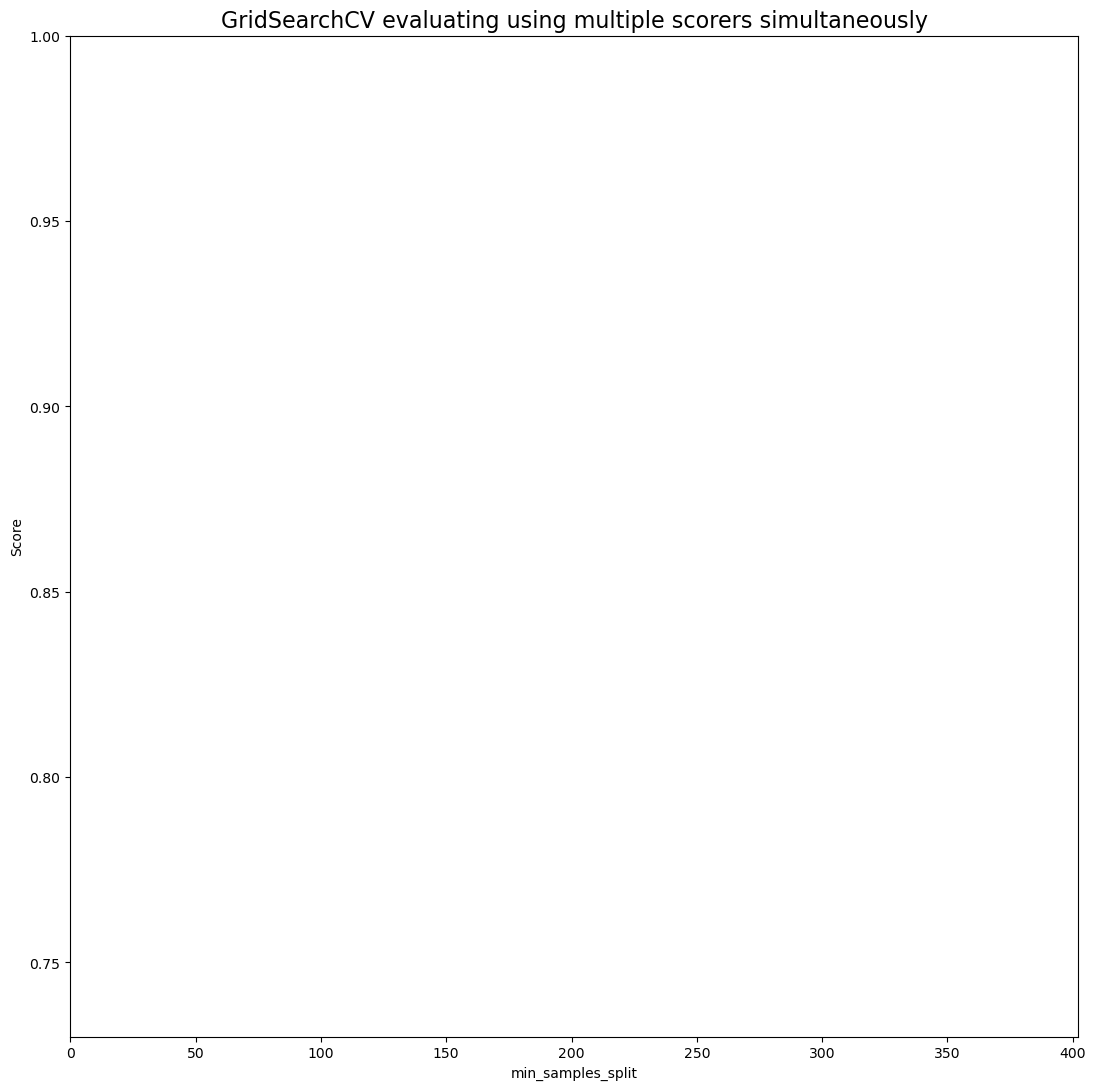

In [69]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

results = Out[65].cv_results_

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_min_samples_split"].data, dtype=float)

for scorer, color in zip(sorted({"AUC": "roc_auc_ovr"}), ["g"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [51]:
rf_clf = RandomForestClassifier(max_depth=25, random_state=42)
rf_clf.fit(X_train_trim, Y_train_trim)
rf_clf.score(X_train_trim, Y_train_trim)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.9857433808553971

In [62]:

roc_auc_score(Y_train_trim,rf_clf.predict_proba(X_train_trim), multi_class='ovr')

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.9999684421077054

In [61]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
clf = rf_clf
y_pred_prob = clf.predict_proba(X_train_trim)[:, 1] 
fpr, tpr, thresholds = roc_curve(Y_train_trim, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(Y_train_trim, y_pred_prob,multi_class='ovr') 
roc_auc


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AxisError: axis 1 is out of bounds for array of dimension 1

In [37]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
le = LabelEncoder()

xgb_clf = XGBClassifier(verbosity=1,n_jobs=-1,eval_metric="merror",early_stopping_rounds=5)

#cross_val_score(xgb_clf, X_train_trim, le.fit_transform(Y_train_trim), cv=5)

In [38]:
X_train_trim=X_train_trim.rename(columns={'VehEngineTokens[231': 'VehEngineTokens{231'})

In [39]:
from sklearn.model_selection import train_test_split
X_tn, X_tt, y_tn, y_tt = train_test_split(X_train_trim, le.fit_transform(Y_train_trim), test_size=0.2, random_state=42)

In [48]:
from sklearn.model_selection import StratifiedKFold
le.fit(Y_train_clean_trim)
train,test = next(StratifiedKFold(n_splits=3).split(X_train_trim, le.transform(Y_train_clean_trim)))
X_train_trim.iloc[train]

,SellerRating,SellerRevCnt,VehListdays,VehMileage,SellerIsPriv,VehCertified,VehPriceLabel_Fair Price,SellerState_MN,SellerState_IL,SellerState_AZ,...,VehColorIntTokens('sienna'; 'brown'),VehColorIntTokens('ski';),VehColorIntTokens('ski'; 'gray'),VehColorIntTokens('sport';),VehColorIntTokens('sugar';),VehColorIntTokens('tan';),VehColorIntTokens('trim';),VehColorIntTokens('unknown';),VehColorIntTokens('w';),VehColorIntTokens('w'; 'dark')
1890,0.059717,0.142033,-0.443410,-0.708147,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
1901,0.727409,-0.304649,-0.718576,0.138979,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1916,0.226640,-0.263417,1.544739,0.717144,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1918,-0.274130,-0.075581,-0.646675,0.569596,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,0,0
1929,-1.025284,-0.277925,-0.443698,-0.440958,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6293,-3.445669,-0.337483,-0.386565,1.751595,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
6294,-0.691437,-0.325266,-0.757948,-0.480967,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
6295,-0.023745,-0.322211,1.923462,-0.770897,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
6296,0.643948,-0.125213,0.269880,0.914876,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [49]:
xgb_clf.fit(X_train_trim.iloc[train], le.transform(Y_train_clean_trim.iloc[train]), verbose=True, eval_set=[(X_train_trim.iloc[test], le.transform(Y_train_clean_trim.iloc[test]))])

#xgb_clf.fit(X_train_trim, le.fit_transform(Y_train_trim),verbose=True,eval_set=[(X_train_trim, le.fit_transform(Y_train_trim))])
#xgb_clf.score(X_train_trim, le.fit_transform(Y_train_trim))

[0]	validation_0-merror:0.08096
[1]	validation_0-merror:0.07790
[2]	validation_0-merror:0.07179
[3]	validation_0-merror:0.07077
[4]	validation_0-merror:0.06466
[5]	validation_0-merror:0.06110
[6]	validation_0-merror:0.06008
[7]	validation_0-merror:0.05754
[8]	validation_0-merror:0.05346
[9]	validation_0-merror:0.05499
[10]	validation_0-merror:0.05295
[11]	validation_0-merror:0.05397
[12]	validation_0-merror:0.05143
[13]	validation_0-merror:0.05092
[14]	validation_0-merror:0.05041
[15]	validation_0-merror:0.05092
[16]	validation_0-merror:0.04888
[17]	validation_0-merror:0.04837
[18]	validation_0-merror:0.04633
[19]	validation_0-merror:0.04735
[20]	validation_0-merror:0.04837
[21]	validation_0-merror:0.04990
[22]	validation_0-merror:0.04990


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [50]:
xgb_clf.score(X_train_trim.iloc[test], le.transform(Y_train_clean_trim.iloc[test]))

0.9536659877800407

In [1]:
from sklearn import datasets
from sklearn import metrics

iris = datasets.load_iris() #dataset loading
X = iris.data               #Features stored in X 
y = iris.target             #Class variable


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_test

array([[6.1, 2.8, 4.7, 1.2],
       [5.7, 3.8, 1.7, 0.3],
       [7.7, 2.6, 6.9, 2.3],
       [6. , 2.9, 4.5, 1.5],
       [6.8, 2.8, 4.8, 1.4],
       [5.4, 3.4, 1.5, 0.4],
       [5.6, 2.9, 3.6, 1.3],
       [6.9, 3.1, 5.1, 2.3],
       [6.2, 2.2, 4.5, 1.5],
       [5.8, 2.7, 3.9, 1.2],
       [6.5, 3.2, 5.1, 2. ],
       [4.8, 3. , 1.4, 0.1],
       [5.5, 3.5, 1.3, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.1, 3.8, 1.5, 0.3],
       [6.3, 3.3, 4.7, 1.6],
       [6.5, 3. , 5.8, 2.2],
       [5.6, 2.5, 3.9, 1.1],
       [5.7, 2.8, 4.5, 1.3],
       [6.4, 2.8, 5.6, 2.2],
       [4.7, 3.2, 1.6, 0.2],
       [6.1, 3. , 4.9, 1.8],
       [5. , 3.4, 1.6, 0.4],
       [6.4, 2.8, 5.6, 2.1],
       [7.9, 3.8, 6.4, 2. ],
       [6.7, 3. , 5.2, 2.3],
       [6.7, 2.5, 5.8, 1.8],
       [6.8, 3.2, 5.9, 2.3],
       [4.8, 3. , 1.4, 0.3],
       [4.8, 3.1, 1.6, 0.2]])

In [4]:
from sklearn import svm
from xgboost import XGBClassifier
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [8]:
clf.fit(X_train, y_train,eval_set=[(X_test,y_test)])

[0]	validation_0-mlogloss:0.72604
[1]	validation_0-mlogloss:0.50842
[2]	validation_0-mlogloss:0.36744
[3]	validation_0-mlogloss:0.27203
[4]	validation_0-mlogloss:0.20487
[5]	validation_0-mlogloss:0.15866
[6]	validation_0-mlogloss:0.12503
[7]	validation_0-mlogloss:0.09808
[8]	validation_0-mlogloss:0.08104
[9]	validation_0-mlogloss:0.06622
[10]	validation_0-mlogloss:0.05690
[11]	validation_0-mlogloss:0.04823
[12]	validation_0-mlogloss:0.04289
[13]	validation_0-mlogloss:0.03730
[14]	validation_0-mlogloss:0.03349
[15]	validation_0-mlogloss:0.02955
[16]	validation_0-mlogloss:0.02698
[17]	validation_0-mlogloss:0.02506
[18]	validation_0-mlogloss:0.02271
[19]	validation_0-mlogloss:0.02059
[20]	validation_0-mlogloss:0.01938
[21]	validation_0-mlogloss:0.01889
[22]	validation_0-mlogloss:0.01871
[23]	validation_0-mlogloss:0.01803
[24]	validation_0-mlogloss:0.01780
[25]	validation_0-mlogloss:0.01736
[26]	validation_0-mlogloss:0.01704
[27]	validation_0-mlogloss:0.01727
[28]	validation_0-mlogloss:0.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [7]:
from sklearn import metrics
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

1.0


In [123]:
from sklearn.model_selection import cross_val_score
models = [RandomForestClassifier(max_depth=25, random_state=42), AdaBoostClassifier(n_estimators=100,random_state=42),KNeighborsClassifier(5),DecisionTreeClassifier(max_depth=50, random_state=42),GaussianNB()]
for model in models:
    print(model,cross_val_score(model, X_train_trim, Y_train_trim, cv=5))

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

RandomForestClassifier(max_depth=25, random_state=42) [0.89906701 0.88379983 0.88964346 0.90322581 0.87266553]


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

AdaBoostClassifier(n_estimators=100, random_state=42) [0.46988974 0.45631891 0.46859083 0.45585739 0.46943973]


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

KNeighborsClassifier() [0.65988126 0.66072943 0.65789474 0.6434635  0.64940577]


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

DecisionTreeClassifier(max_depth=50, random_state=42) [0.91857506 0.92196777 0.91595925 0.93463497 0.9040747 ]


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

GaussianNB() [0.67938931 0.68108567 0.68421053 0.66383701 0.66213922]


In [82]:
feature ="VehFeatTokens"
mlb = MultiLabelBinarizer(sparse_output=True).fit(pd.concat([train[feature],test[feature]],ignore_index=True))
temp = pd.DataFrame.sparse.from_spmatrix(mlb.transform(train[feature]),columns=[feature+str(c) for c in mlb.classes_],index=train.index)
print(temp.info())
temp.loc[:,temp.sum()>=5]

<class 'pandas.core.frame.DataFrame'>
Index: 6297 entries, 0 to 6297
Columns: 4973 entries, VehFeatTokens('0',) to VehFeatTokens('zones',)
dtypes: Sparse[int64, 0](4973)
memory usage: 3.8 MB
None


,"VehFeatTokens('0',)","VehFeatTokens('0', 'aluminumradio')","VehFeatTokens('0', 'p')","VehFeatTokens('0', 'x27')","VehFeatTokens('000',)","VehFeatTokens('000', 'mile')","VehFeatTokens('09',)","VehFeatTokens('09', 'rear')","VehFeatTokens('0in',)","VehFeatTokens('0in', 'aluminum')",...,"VehFeatTokens('year', 'siriusxm')","VehFeatTokens('you',)","VehFeatTokens('yr',)","VehFeatTokens('yr', 'siriusxm')","VehFeatTokens('zone',)","VehFeatTokens('zone', 'a')","VehFeatTokens('zone', 'automatic')","VehFeatTokens('zone', 'automaticwith')","VehFeatTokens('zone', 'climate')","VehFeatTokens('zones',)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6297 entries, 0 to 6297
Columns: 133091 entries, SellerRating to VehColorIntTokens('with', 'mini')
dtypes: Sparse[int64, 0](132980), bool(107), float64(4)
memory usage: 25.4 MB


In [70]:
with open('your_file.txt', 'w') as f:
    for line in sorted(X_train.columns):
        f.write(f"{line}\n")

In [104]:
rf_clf = RandomForestClassifier(max_depth=25, random_state=42)
rf_clf.fit(X_train_trim, Y_train_clean_trim)
rf_clf.score(X_train_trim, Y_train_trim),rf_clf.score(X_train_trim, Y_train_clean_trim)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


(0.9517990495587237, 0.9859131025118805)

In [105]:
rf_clf.fit(X_train_trim, Y_train_trim)
rf_clf.score(X_train_trim, Y_train_trim)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.9874405974202308

In [108]:
cross_val_score(rf_clf, X_train_trim, Y_train_trim, cv=5)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

array([0.89906701, 0.88379983, 0.88964346, 0.90322581, 0.87266553])

In [109]:
cross_val_score(rf_clf, X_train_trim, Y_train_clean_trim, cv=5)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

array([0.90076336, 0.90415606, 0.9040747 , 0.92020374, 0.90067912])

In [121]:

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
for i, (train_index, test_index) in enumerate(kf.split(X_train_trim)):
    print(f"Fold {i}:")
    rf_clf.fit(X_train_trim.iloc[train_index], Y_train_clean_trim.iloc[train_index])
    print(rf_clf.score(X_train_trim.iloc[test_index], Y_train_trim.iloc[test_index]))

Fold 0:


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8770144189991518
Fold 1:


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8625954198473282
Fold 2:


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8607809847198642
Fold 3:


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8777589134125636
Fold 4:


/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8726655348047538


In [119]:
X_train_trim.iloc[test_index]

,SellerRating,SellerRevCnt,VehListdays,VehMileage,SellerIsPriv,VehCertified,SellerState_MN,VehFuel_Diesel,VehYear_2017,SellerDivision_South Atlantic,...,"VehColorIntTokens('sienna', 'brown')","VehColorIntTokens('ski',)","VehColorIntTokens('ski', 'gray')","VehColorIntTokens('sport',)","VehColorIntTokens('sugar',)","VehColorIntTokens('tan',)","VehColorIntTokens('trim',)","VehColorIntTokens('unknown',)","VehColorIntTokens('w',)","VehColorIntTokens('w', 'dark')"
0,0.727409,-0.313049,-0.701962,1.005301,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,0.560486,0.735320,-0.411505,0.977395,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,0.226640,-0.321448,0.060653,-0.452830,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,-0.357591,-0.280979,0.639104,-0.500316,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
5,-0.941822,-0.298541,-0.368912,0.645297,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6293,-3.445669,-0.337483,-0.386565,1.751595,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
6294,-0.691437,-0.325266,-0.757948,-0.480967,False,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0
6295,-0.023745,-0.322211,1.923462,-0.770897,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
6296,0.643948,-0.125213,0.269880,0.914876,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0


In [97]:
rf_clf.score(X_train_trim, Y_train_trim)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.9859131025118805

In [98]:
cross_val_score(rf_clf, X_train_trim, Y_train_trim, cv=5)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

array([0.90076336, 0.90415606, 0.9040747 , 0.92020374, 0.90067912])

In [ ]:
rf_clf = RandomForestClassifier(max_depth=25, random_state=42)
rf_clf.fit(X_scaled, Y_train_trim)

ab_clf = AdaBoostClassifier(n_estimators=100,random_state=42)
ab_clf.fit(X_scaled, Y_train_trim)

kn_clf = KNeighborsClassifier(5)
kn_clf.fit(X_scaled, Y_train_trim)

dt_clf = DecisionTreeClassifier(max_depth=50, random_state=42)
dt_clf.fit(X_scaled, Y_train_trim)

nb_clf = GaussianNB()
nb_clf.fit(X_scaled, Y_train_trim)

models = [rf_clf,ab_clf,kn_clf,dt_clf,nb_clf]

In [75]:
rf_clf.score(X_train_trim, Y_train_trim)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.9582484725050916

In [74]:
rf_clf.score(X_train_trim, Y_train_trim), ab_clf.score(X_scaled, Y_train_trim), kn_clf.score(X_scaled, Y_train_trim), dt_clf.score(X_scaled, Y_train_trim), nb_clf.score(X_scaled, Y_train_trim), 

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


NameError: name 'ab_clf' is not defined

In [77]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf_clf, X_train_trim, Y_train_trim, cv=5)

/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/hazeneckert/miniconda3/envs/practice/lib/python3.11/site-packages/sklearn/utils/validation.py:768

array([0.84308736, 0.83884648, 0.85314092, 0.84634975, 0.84040747])

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

train_ext_colors = sorted(train["VehColorExt"].unique())
train_ext_color_tokens = set(["ext_"+token for color in train_ext_colors for token in color.split()])
test_ext_colors = sorted(test["VehColorExt"].unique())
test_ext_color_tokens = set(["int_"+token for color in test_ext_colors for token in color.split()])

ext_mlb = MultiLabelBinarizer(sparse_output=True)
ext_mlb.fit([sorted(train_ext_color_tokens.union(test_ext_color_tokens))])

ext_color_features_train = pd.DataFrame.sparse.from_spmatrix(ext_mlb.transform(train["VehColorExt"].str.split().apply(lambda l : ["ext_"+s for s in l])),index=train.index,
                columns=ext_mlb.classes_)
ext_color_features_test = pd.DataFrame.sparse.from_spmatrix(ext_mlb.transform(test["VehColorExt"].str.split().apply(lambda l : ["int_"+s for s in l])),index=test.index,
                columns=ext_mlb.classes_)

train_int_colors = sorted(train["VehColorInt"].unique())
train_int_color_tokens = set([token for color in train_int_colors for token in color.split()])
test_int_colors = sorted(test["VehColorInt"].unique())
test_int_color_tokens = set([token for color in test_int_colors for token in color.split()])

int_mlb = MultiLabelBinarizer(sparse_output=True)
int_mlb.fit([sorted(train_int_color_tokens.union(test_int_color_tokens))])

int_color_features_train = pd.DataFrame.sparse.from_spmatrix(int_mlb.transform(train["VehColorInt"].str.split()),index=train.index,
                columns=int_mlb.classes_)
int_color_features_test = pd.DataFrame.sparse.from_spmatrix(int_mlb.transform(test["VehColorInt"].str.split()),index=test.index,
                columns=int_mlb.classes_)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

train_ext_colors = sorted(train["VehColorExt"].unique())
train_ext_color_tokens = set(["ext_"+token for color in train_ext_colors for token in color.split()])
test_ext_colors = sorted(test["VehColorExt"].unique())
test_ext_color_tokens = set(["int_"+token for color in test_ext_colors for token in color.split()])

ext_mlb = MultiLabelBinarizer(sparse_output=False)
ext_mlb.fit([sorted(train_ext_color_tokens.union(test_ext_color_tokens))])

ext_color_features_train = pd.DataFrame(ext_mlb.transform(train["VehColorExt"].str.split().apply(lambda l : ["ext_"+s for s in l])),index=train.index,
                columns=ext_mlb.classes_)
ext_color_features_test = pd.DataFrame(ext_mlb.transform(test["VehColorExt"].str.split().apply(lambda l : ["int_"+s for s in l])),index=test.index,
                columns=ext_mlb.classes_)

train_int_colors = sorted(train["VehColorInt"].unique())
train_int_color_tokens = set([token for color in train_int_colors for token in color.split()])
test_int_colors = sorted(test["VehColorInt"].unique())
test_int_color_tokens = set([token for color in test_int_colors for token in color.split()])

int_mlb = MultiLabelBinarizer(sparse_output=False)
int_mlb.fit([sorted(train_int_color_tokens.union(test_int_color_tokens))])

int_color_features_train = pd.DataFrame(int_mlb.transform(train["VehColorInt"].str.split()),index=train.index,
                columns=int_mlb.classes_)
int_color_features_test = pd.DataFrame(int_mlb.transform(test["VehColorInt"].str.split()),index=test.index,
                columns=int_mlb.classes_)

In [ ]:
train.info()

In [ ]:
print(Y_train_trim.value_counts(), 1/len(Y_train_trim.unique()))

In [ ]:
from sklearn.model_selection import cross_val_score
for model in models:
    print(model,cross_val_score(model, X_scaled, Y_train_trim, cv=5))

In [ ]:
df = X_train_trim.copy()
df["Predicted_Trim"] = pd.DataFrame(rf_clf.predict(X_scaled),index=X_train_trim.index)
df["Cleaned_Trim"]=Y_train_trim
mcX= df[df["Predicted_Trim"]!=df["Cleaned_Trim"]]
misclass=train.loc[mcX.index.tolist()]
misclass.describe(include='all')

In [ ]:
mcX.groupby(["Cleaned_Trim","Predicted_Trim"]).size()

In [ ]:
mcX.groupby(["Cleaned_Trim","Predicted_Trim"]).count()

In [ ]:
mcX["Cleaned_Trim"].value_counts()

In [ ]:
misclass["Vehicle_Trim_Extraction"].value_counts()

In [ ]:
misclass[misclass["Vehicle_Trim_Extraction"]=="Limited"]["VehSellerNotes"]

In [ ]:
misclass["Vehicle_Trim"].value_counts()

In [ ]:
train[~train["Vehicle_Trim_Clean"].isnull()]["Vehicle_Trim_Clean"].value_counts()

In [ ]:
train["Vehicle_Trim_Clean"].value_counts().nlargest(30)

In [ ]:
train[train["Vehicle_Trim_Clean"]=="Base"]["VehMake"].unique()

In [ ]:
train.loc[9]["VehFeats"]

In [ ]:
train.loc[9]["VehSellerNotes"]

In [ ]:
{y for x in train["VehFeats"] if not pd.isnull(x) for y in eval(x)}

In [ ]:
df =pd.DataFrame([token for color in train["VehColorExt"] for token in color.split()])
df.value_counts().nlargest(50)

In [ ]:
train_colors = sorted(train["VehColorExt"].unique())
train_color_tokens = set([token for color in train_colors for token in color.split()])
test_colors = sorted(test["VehColorExt"].unique())
test_color_tokens = set([token for color in test_colors for token in color.split()])


In [ ]:
train[train["VehEngineClean"]=="unknown"]["VehTransmission"].unique()

In [ ]:
test.iloc[960]['VehFeats']

In [ ]:
df = train[train["VehEngineClean"]=="unknown"]
df[df["Vehicle_Trim"].notnull()]
#train.iloc[2797]["VehSellerNotes"]

In [ ]:
for n in test[test["VehEngineClean"]=="6.4L V8"].index:
    print(n,train.iloc[n]['VehFeats'])
    #print(n,train.iloc[n]['VehSellerNotes'])


In [ ]:
for n in test[test["VehEngineClean"]=="5.7L V8"].index:
    print(n,train.iloc[n]['VehFeats'])

In [ ]:
train.iloc[3037]["VehFeats"]

In [ ]:
df = train[train["VehFuel"]=='Diesel']
df["VehEngine"].value_counts().nlargest(40)

In [ ]:
test["VehModel"].value_counts().nlargest(40)

In [ ]:
train.groupby(["VehModel","VehYear"]).count()

In [ ]:
train.groupby(["Vehicle_Trim"])["Dealer_Listing_Price"].mean()

In [ ]:
print(train.iloc[1125])

In [ ]:
print(train.iloc[1125])
print(train.iloc[3267])

In [ ]:
train[train["SellerName"]=="Cadillac of Bellevue"]

In [ ]:
train[train["SellerName"]=="Jack Demmer Lincoln"]

In [ ]:
train[train["SellerCity"]=="dearborn"]

In [ ]:
train[train["SellerListSrc"]=="Digital Motorworks (DMi)"]

In [ ]:
cities = train["SellerCity"].unique()
misspellings = [ (x,y) for x in cities for y in cities if x!=y and edit_distance(x,y)<2]
misspellings

In [ ]:
train.info(), test.info()

In [ ]:
train.head()

In [ ]:
train.nunique(), test.nunique()

In [ ]:
train.isnull().sum(),test.isnull().sum()

In [ ]:
len(sorted(train['SellerCity'].unique()))

In [ ]:
len(sorted(train['SellerCity'].unique()))

In [ ]:
train['SellerCity'].value_counts().nlargest(50), test['SellerCity'].value_counts().nlargest(50)

In [ ]:
len(set(test['SellerCity'])-set(train['SellerCity'])),len(set(test['SellerCity'])&set(train['SellerCity']))

In [ ]:
train['SellerIsPriv'].value_counts(),test['SellerIsPriv'].value_counts()

In [ ]:
train['SellerListSrc'].unique()

In [ ]:
train['SellerListSrc'].value_counts().nlargest(20)

In [ ]:
set(test['SellerListSrc'])-set(train['SellerListSrc'])

In [ ]:
print(set(test['SellerName'])-set(train['SellerName']))
sorted(train['SellerName'].unique())

In [ ]:
train['SellerName'].value_counts().nlargest(20)

In [ ]:
train[train['SellerListSrc'].isnull()]

In [ ]:
np.count_nonzero(train['SellerRating']),np.count_nonzero(train['SellerRevCnt'])

In [ ]:
train['SellerState'].value_counts().nsmallest(10),test['SellerState'].value_counts().nsmallest(10)

In [ ]:
set(train['SellerState'])-set(test['SellerState'])

In [ ]:
train['VehCertified'].describe(), test['VehCertified'].describe()

In [ ]:
train['VehColorExt'].value_counts().nlargest(50)

In [ ]:
train['VehColorExt'].describe()

In [ ]:
train['VehColorInt'].value_counts().nlargest(50)

In [ ]:
train['VehDriveTrain'].value_counts().nlargest(40),test['VehDriveTrain'].value_counts().nlargest(40)

In [ ]:
train['VehEngine'].value_counts().nlargest(30)

In [ ]:
train['VehFeats'].value_counts().nlargest(10)

In [ ]:
train['VehFuel'].value_counts().nlargest(30)

In [ ]:
test['VehFuel'].value_counts().nlargest(30)

In [ ]:
train['VehHistory'].value_counts().nlargest(30)

In [ ]:
df =train[train['SellerListSrc'].isnull()]
df['VehListdays']

In [ ]:
train['VehListdays'].value_counts().nlargest(10),train['VehListdays'].value_counts().nsmallest(10)

In [ ]:
sorted(train['VehListdays'].unique())

In [ ]:
train['VehMake'].unique(),train['VehModel'].unique()

In [ ]:
test['VehMake'].unique(),test['VehModel'].unique()

In [ ]:
train['VehPriceLabel'].value_counts().nlargest(10),test['VehPriceLabel'].value_counts().nlargest(10)

In [ ]:
train['VehSellerNotes'].value_counts().nlargest(10)

In [ ]:
train['VehType'].unique(),test['VehType'].unique(),

In [ ]:
train['VehTransmission'].value_counts().nlargest(40),test['VehTransmission'].value_counts().nlargest(40)

In [ ]:
sorted(train['VehYear'].unique()), sorted(test['VehYear'].unique())

In [ ]:
train['Vehicle_Trim'].unique()

In [ ]:
train['Dealer_Listing_Price'].describe()

- Delete ListingID
- Delete VehBodystyle
- Delete VehType
- Consolidate references to engine type in VehEngine and add an 'Unknown' category for nulls.
- Consolidate references to drive train in VehDriveTrain and add an 'Unknown' category for nulls.
- Set null values to 'Unkown' in VehFuel
- Use one of VehMake or VehModel
- Add 'Unknown' to VehPriceLabel for nulls

In [ ]:
train.at["SellerZip",3855]=48124

In [ ]:
train['VehFeats']

In [ ]:
train.iloc[1125]